In [1]:
%pip install gensim -q

In [2]:
# Config
import requests
import re
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from collections import Counter
from scipy.spatial.distance import cosine
import random

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

### Preparação dos Dados (Corpus Toy)
Definindo um conjunto de frases simples onde "rei" e "rainha" aparecem em contextos similares,
assim como "maca" e "laranja".

In [3]:
corpus_raw = [
    "o rei governa o reino",
    "a rainha governa o reino",
    "o rei tem uma coroa",
    "a rainha tem uma coroa",
    "a maca e uma fruta",
    "a laranja e uma fruta",
    "eu gosto de comer maca",
    "eu gosto de comer laranja",
    "o reino e grande",
    "a fruta e doce"
]

# Tokenização simples
tokenized_corpus = [sentence.split() for sentence in corpus_raw]
vocab = sorted(list(set([word for sentence in tokenized_corpus for word in sentence])))
word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for i, w in enumerate(vocab)}
vocab_size = len(vocab)
embedding_dim = 5 # Dimensão baixa para facilitar a evolução

print(f"Vocabulário ({vocab_size} palavras): {vocab}")

Vocabulário (19 palavras): ['a', 'comer', 'coroa', 'de', 'doce', 'e', 'eu', 'fruta', 'gosto', 'governa', 'grande', 'laranja', 'maca', 'o', 'rainha', 'rei', 'reino', 'tem', 'uma']


### Gerar pares de treinamento (Target, Context) - Lógica Skip-gram
O Skip-Gram é uma das arquiteturas do algoritmo Word2Vec. A sua lógica fundamental é inversa à intuição comum: em vez de usar o contexto para prever uma palavra, ele usa uma palavra central para prever o contexto.

In [4]:
window_size = 2
pairs_input = []
pairs_target = []
for sentence in tokenized_corpus:
    indices = [word2idx[w] for w in sentence]
    for i, target in enumerate(indices):
        start = max(0, i - window_size)
        end = min(len(indices), i + window_size + 1)
        for j in range(start, end):
            if i != j:
                pairs_input.append(target)
                pairs_target.append(indices[j])

inputs_np = np.array(pairs_input)
targets_np = np.array(pairs_target)
print(f"Total de pares de treino: {len(inputs_np)}")

Total de pares de treino: 132


### Embeddings por Algoritmos Genéticos

In [5]:
class GeneticEmbedding:
    def __init__(self, n_vocab, dim, pop_size=10, mutation_rate=0.05):
        self.n_vocab = n_vocab
        self.dim = dim
        self.pop_size = pop_size
        self.mutation_rate = mutation_rate
        # Inicializa população
        self.population = [np.random.uniform(-1, 1, (n_vocab, dim)) for _ in range(pop_size)]

    def fitness(self, matrix):   
        norm = np.linalg.norm(matrix, axis=1, keepdims=True)
        matrix_norm = matrix / (norm + 1e-9)

        # Atração
        vec_inputs = matrix_norm[inputs_np]
        vec_targets = matrix_norm[targets_np]
        
        # Dot product linha a linha (similaridade)
        # axis=1 soma as multiplicações das dimensões
        pos_scores = np.sum(vec_inputs * vec_targets, axis=1)
        
        # Repulsão (Negative Sampling)
        neg_indices = np.random.randint(0, self.n_vocab, size=len(inputs_np))
        vec_negs = matrix_norm[neg_indices]
        
        neg_scores = np.sum(vec_inputs * vec_negs, axis=1)
        
        # Score final: Média dos Positivos - Média dos Negativos
        return np.mean(pos_scores) - np.mean(neg_scores)

    def evolve(self, generations=50):
        for gen in range(generations + 1):
            scores = [(ind, self.fitness(ind)) for ind in self.population]
            scores.sort(key=lambda x: x[1], reverse=True)
            
            best_score = scores[0][1]
            if gen % 10 == 0:
                print(f"Gen {gen}: Score = {best_score:.4f}")
            
            # Elitismo + Reprodução
            survivors = [s[0] for s in scores[:5]]
            new_pop = survivors[:]
            
            while len(new_pop) < self.pop_size:
                parent = random.choice(survivors)
                child = np.copy(parent)
                
                # Mutação Otimizada
                mask = np.random.rand(*child.shape) < self.mutation_rate
                noise = np.random.normal(0, 0.5, child.shape) # Ruído maior
                child[mask] += noise[mask]
                new_pop.append(child)
            
            self.population = new_pop
        
        return scores[0][0]

# Rodar EA
ea_model = GeneticEmbedding(vocab_size, embedding_dim, pop_size=15, mutation_rate=0.1)
ea_matrix = ea_model.evolve(generations=200)
ea_matrix

Gen 0: Score = 0.0626
Gen 10: Score = 0.1458
Gen 20: Score = 0.2385
Gen 30: Score = 0.2581
Gen 40: Score = 0.3392
Gen 50: Score = 0.3081
Gen 60: Score = 0.3798
Gen 70: Score = 0.3719
Gen 80: Score = 0.4297
Gen 90: Score = 0.4181
Gen 100: Score = 0.4273
Gen 110: Score = 0.4284
Gen 120: Score = 0.4550
Gen 130: Score = 0.4495
Gen 140: Score = 0.4445
Gen 150: Score = 0.4930
Gen 160: Score = 0.4979
Gen 170: Score = 0.4810
Gen 180: Score = 0.4641
Gen 190: Score = 0.4399
Gen 200: Score = 0.4983


array([[-0.28205714, -1.93683408,  0.67556684,  4.57872032, -1.29514439],
       [-0.6442146 , -1.66011795, -0.42679077, -1.70629227, -0.75130092],
       [-0.5458636 ,  0.23795905, -2.59293982,  2.99665961,  0.65021388],
       [ 0.07260651, -2.21468776, -0.93943452, -1.28512882, -0.80534457],
       [-1.20538017,  1.56700423, -2.96844926,  1.61668482,  0.7749379 ],
       [ 1.22913203,  1.04727351, -1.62793515,  2.36458927,  3.26555305],
       [-0.02967725, -1.30837109, -1.01765169, -1.41883333, -1.38570633],
       [ 1.74225427,  0.48517294, -0.97771308,  0.63718665,  0.75917744],
       [-0.40603551, -2.00658428,  1.12838029, -4.29591611, -2.11335529],
       [-1.21194748,  2.18616697,  3.72967035,  1.1056114 , -1.83651122],
       [ 1.88068896,  0.54080939, -2.61715752,  2.58757003,  3.25798934],
       [-0.03314412, -1.12075492, -2.42990868, -1.63179504,  1.2363563 ],
       [-0.4469428 , -1.25932861, -0.58144596, -0.26288903, -0.58795895],
       [ 1.41386983,  1.31651815,  3.7

### O Benchmark Consagrado (Gensim Word2Vec)

In [6]:
w2v_model = Word2Vec(sentences=tokenized_corpus, vector_size=embedding_dim, window=2, min_count=1, epochs=100, sg=1)
w2v_matrix = np.array([w2v_model.wv[word] for word in vocab])
w2v_matrix

array([[-0.01305044,  0.0109564 ,  0.10854632,  0.17856686, -0.18934242],
       [-0.15386003, -0.01135204,  0.19576642, -0.14931247, -0.04959152],
       [-0.03304486,  0.01026156, -0.07871778, -0.15568934, -0.03277951],
       [-0.0448953 ,  0.17057537, -0.11210905, -0.00374039, -0.0994449 ],
       [ 0.03753305,  0.12266687, -0.09497645, -0.06232034,  0.13616076],
       [ 0.14497444, -0.02356986, -0.08381974,  0.12919885, -0.10161636],
       [-0.00994451, -0.14663151,  0.19668277,  0.09715442,  0.18114705],
       [ 0.14448665,  0.10633168,  0.139965  ,  0.01373336,  0.12348361],
       [-0.19576883,  0.10720661, -0.16957973, -0.09065504, -0.00449346],
       [ 0.00930927,  0.1524059 , -0.01397417, -0.0555374 , -0.17815556],
       [ 0.03149683,  0.00677393,  0.07221378,  0.00307499,  0.19053373],
       [-0.16537577,  0.09365896, -0.08016176,  0.01438621,  0.16802709],
       [-0.09207066,  0.09486651, -0.13188988, -0.07321968,  0.18550657],
       [-0.14951797,  0.14149296,  0.1

### Reduzindo para duas dimensões com PCA e plottando

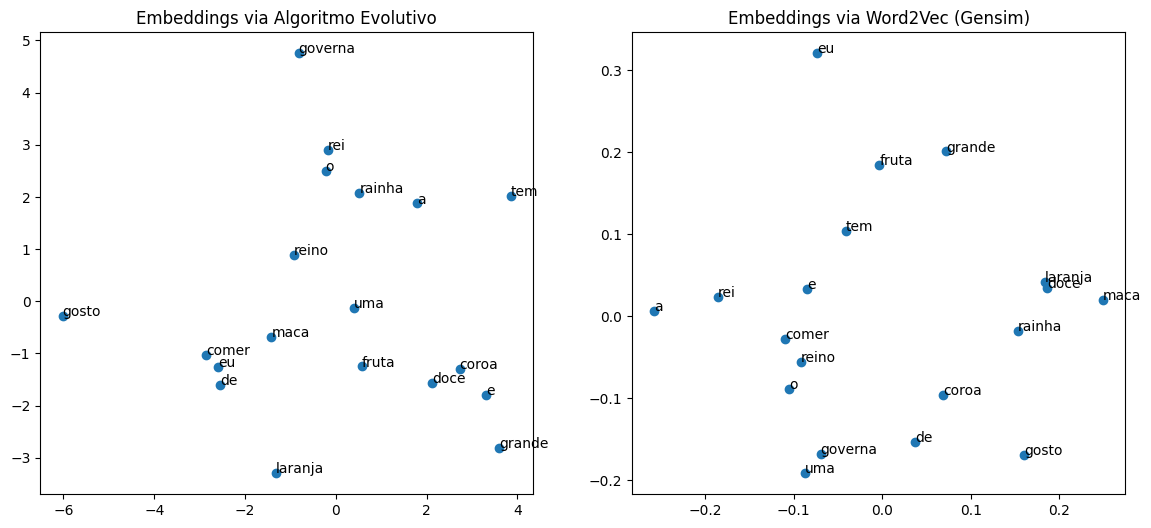

In [7]:
def plot_embeddings(matrix, title, ax):
    pca = PCA(n_components=2)
    result = pca.fit_transform(matrix)
    ax.scatter(result[:, 0], result[:, 1])
    
    for i, word in enumerate(vocab):
        ax.annotate(word, xy=(result[i, 0], result[i, 1]))
    ax.set_title(title)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

plot_embeddings(ea_matrix, "Embeddings via Algoritmo Evolutivo", ax1)
plot_embeddings(w2v_matrix, "Embeddings via Word2Vec (Gensim)", ax2)

plt.show()

### Verificando o desempenho em palavras que entendemos a similaridade.

In [8]:
def get_dist(matrix, w1, w2):
    v1 = matrix[word2idx[w1]]
    v2 = matrix[word2idx[w2]]
    return cosine(v1, v2)

print("\n--- Teste de Sanidade (Distância Cosseno: menor é melhor) ---")
print(f"EA -> Rei vs Rainha: {get_dist(ea_matrix, 'rei', 'rainha'):.4f}")
print(f"EA -> Rei vs Maca:   {get_dist(ea_matrix, 'rei', 'maca'):.4f}")
print("-" * 30)
print(f"W2V -> Rei vs Rainha: {get_dist(w2v_matrix, 'rei', 'rainha'):.4f}")
print(f"W2V -> Rei vs Maca:   {get_dist(w2v_matrix, 'rei', 'maca'):.4f}")


--- Teste de Sanidade (Distância Cosseno: menor é melhor) ---
EA -> Rei vs Rainha: 0.5261
EA -> Rei vs Maca:   1.4620
------------------------------
W2V -> Rei vs Rainha: 1.4754
W2V -> Rei vs Maca:   1.6417


Podemos ver que o AG desempenhou melhor em um dataset pequeno, controlado e de vocabulários reduzido, mas e para um texto real?

### Utilizando *Alice no País das Maravilhas*

In [9]:
print("Baixando dataset 'Alice in Wonderland'...")
url = "https://www.gutenberg.org/files/11/11-0.txt"
text = requests.get(url).text
print(f"Trecho Aleatório: \n==========\n'...{text[3000:3300]}'...'\n==========\n")

# Limpeza: lowercase, remove pontuação e quebras de linha
text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
words = text.split()

# Filtragem de Stopwords simples (manual para não depender de NLTK)
stopwords = set(['the', 'and', 'to', 'a', 'of', 'it', 'she', 'said', 'in', 'was', 'that', 'i', 'as', 'her', 'at', 'on', 'with', 'all', 'had', 'but', 'for', 'so', 'be', 'not', 'what', 'this', 'you', 'is'])
filtered_words = [w for w in words if w not in stopwords and len(w) > 2]

# Manter apenas TOP N palavras
VOCAB_SIZE = 300
counter = Counter(filtered_words)
common_words = [w for w, _ in counter.most_common(VOCAB_SIZE)]
vocab_set = set(common_words)
embedding_dim = 10

# Recriar corpus apenas com palavras conhecidas
final_corpus = [w for w in filtered_words if w in vocab_set]

# Mapeamentos
word2idx = {w: i for i, w in enumerate(common_words)}
idx2word = {i: w for i, w in enumerate(common_words)}

print(f"Dataset pronto: {len(final_corpus)} tokens totais, Vocabulário reduzido para top {VOCAB_SIZE} palavras.")
final_corpus

Baixando dataset 'Alice in Wonderland'...
Trecho Aleatório: 
'... it into one of the
cupboards as she fell past it.

“Well!” thought Alice to herself, “after such a fall as this, I shall
think nothing of tumbling down stairs! How brave they’ll all think me
at home! Why, I wouldn’t say anything about it, even if I fell off the
top of the house!” (Which was very li'...'

Dataset pronto: 9514 tokens totais, Vocabulário reduzido para top 300 palavras.


['alices',
 'chapter',
 'down',
 'chapter',
 'pool',
 'tears',
 'chapter',
 'long',
 'chapter',
 'rabbit',
 'little',
 'bill',
 'chapter',
 'from',
 'caterpillar',
 'chapter',
 'chapter',
 'mad',
 'chapter',
 'chapter',
 'mock',
 'chapter',
 'chapter',
 'who',
 'chapter',
 'alices',
 'chapter',
 'down',
 'alice',
 'beginning',
 'get',
 'very',
 'sitting',
 'having',
 'nothing',
 'once',
 'into',
 'use',
 'thought',
 'alice',
 'without',
 'own',
 'mind',
 'well',
 'could',
 'day',
 'made',
 'very',
 'whether',
 'would',
 'getting',
 'when',
 'suddenly',
 'white',
 'rabbit',
 'eyes',
 'ran',
 'close',
 'there',
 'nothing',
 'very',
 'did',
 'alice',
 'think',
 'very',
 'much',
 'out',
 'way',
 'hear',
 'rabbit',
 'say',
 'itself',
 'dear',
 'dear',
 'shall',
 'when',
 'thought',
 'over',
 'ought',
 'have',
 'time',
 'seemed',
 'quite',
 'when',
 'rabbit',
 'took',
 'out',
 'its',
 'looked',
 'then',
 'hurried',
 'alice',
 'feet',
 'mind',
 'never',
 'before',
 'seen',
 'rabbit',
 'take',

### Mesma lógica do Skip-Gram vista anteriormente

In [10]:
window_size = 2
pairs_input = []
pairs_target = []

for i, target_word in enumerate(final_corpus):
    target_idx = word2idx[target_word]
    start = max(0, i - window_size)
    end = min(len(final_corpus), i + window_size + 1)
    
    for j in range(start, end):
        if i != j:
            context_word = final_corpus[j]
            pairs_input.append(target_idx)
            pairs_target.append(word2idx[context_word])

# Converter para Numpy Array para velocidade extrema
inputs_np = np.array(pairs_input)
targets_np = np.array(pairs_target)
print(f"Total de pares de treino gerados: {len(inputs_np)}")

Total de pares de treino gerados: 38050


In [11]:
ea_model = GeneticEmbedding(VOCAB_SIZE, embedding_dim, pop_size=15, mutation_rate=0.1)
ea_matrix = ea_model.evolve(generations=100)
norm = np.linalg.norm(ea_matrix, axis=1, keepdims=True)
ea_matrix = ea_matrix / (norm + 1e-9)
ea_matrix

Gen 0: Score = 0.0141
Gen 10: Score = 0.0266
Gen 20: Score = 0.0288
Gen 30: Score = 0.0292
Gen 40: Score = 0.0301
Gen 50: Score = 0.0329
Gen 60: Score = 0.0348
Gen 70: Score = 0.0370
Gen 80: Score = 0.0411
Gen 90: Score = 0.0397
Gen 100: Score = 0.0385


array([[ 0.10012138, -0.19044211, -0.51978685, ..., -0.3602933 ,
        -0.17337912, -0.3852116 ],
       [-0.06293786, -0.074405  , -0.48560089, ..., -0.23676674,
        -0.36207773, -0.52510123],
       [-0.59442512,  0.03611402,  0.29896738, ..., -0.24812063,
        -0.03645848,  0.22715625],
       ...,
       [ 0.48596251,  0.27306759,  0.21445639, ..., -0.45945939,
         0.17143744,  0.02920389],
       [ 0.40335758, -0.00262558, -0.02844234, ..., -0.36037064,
         0.47080961, -0.15858514],
       [ 0.06631205,  0.02092007, -0.01404232, ..., -0.31994414,
         0.76185018,  0.1537746 ]])

In [12]:
sentences = [final_corpus]
w2v_model = Word2Vec(sentences, vector_size=embedding_dim, window=2, min_count=1, epochs=100, sg=1)
w2v_matrix = np.array([w2v_model.wv[w] for w in common_words])
w2v_matrix

array([[ 0.2498473 ,  0.08512861,  0.6735682 , ...,  0.32303727,
        -0.36556587, -0.37345847],
       [ 0.12546661, -0.3632963 ,  0.5529233 , ...,  0.46581498,
        -0.7353506 , -0.26391116],
       [ 0.23481886, -0.11119093,  0.17905293, ...,  0.67373455,
        -0.36166012, -0.35442442],
       ...,
       [-0.79924554,  0.20888285,  0.8171349 , ...,  1.4076619 ,
         0.06279338, -0.31382608],
       [ 0.21168746, -0.7358826 ,  1.0545756 , ...,  1.237858  ,
         0.52744144,  0.48721716],
       [ 0.50416994,  0.02055334,  0.3086924 , ...,  1.0441183 ,
        -0.3534808 , -0.48811534]], dtype=float32)

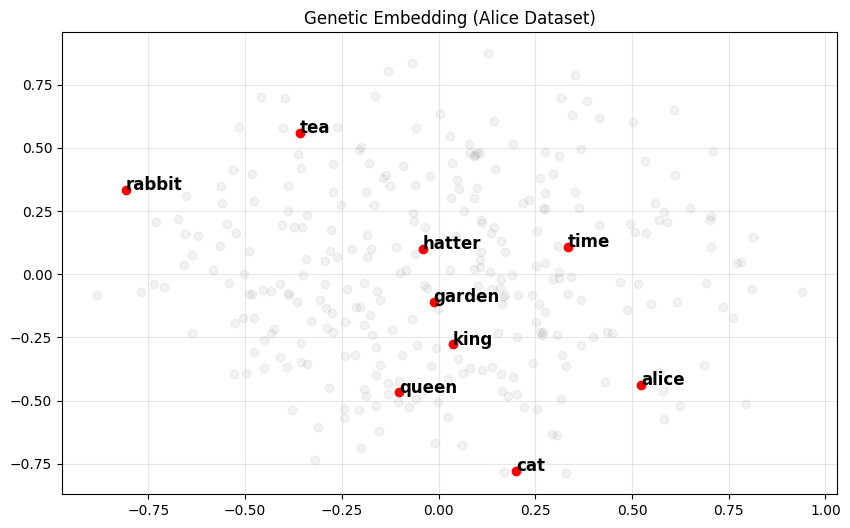

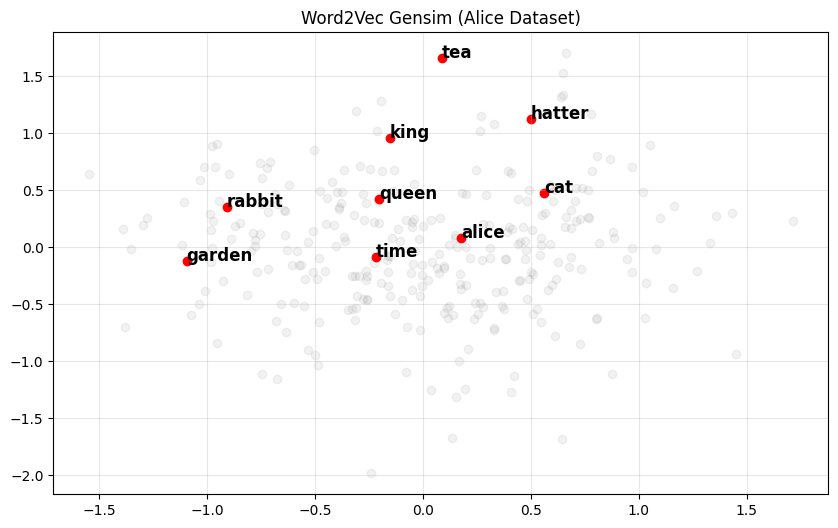

In [13]:
def plot_comparison(matrix, title, words_of_interest):
    # Redução para 2D
    pca = PCA(n_components=2)
    coords = pca.fit_transform(matrix)
    
    plt.figure(figsize=(10, 6))
    plt.title(title)
    
    # Plotar apenas palavras de interesse para não poluir
    indices = [word2idx[w] for w in words_of_interest if w in word2idx]
    
    plt.scatter(coords[:, 0], coords[:, 1], alpha=0.1, color='gray') # Fundo
    
    for idx in indices:
        x, y = coords[idx]
        plt.scatter(x, y, color='red')
        plt.text(x, y, idx2word[idx], fontsize=12, fontweight='bold')
        
    plt.grid(True, alpha=0.3)
    plt.show()

# Palavras chave de Alice in Wonderland para testar agrupamento
test_words = ['alice', 'queen', 'king', 'cat', 'rabbit', 'hatter', 'tea', 'time', 'garden']

plot_comparison(ea_matrix, "Genetic Embedding (Alice Dataset)", test_words)
plot_comparison(w2v_matrix, "Word2Vec Gensim (Alice Dataset)", test_words)

In [14]:
def get_neighbors(target, matrix, k=5):
    if target not in word2idx: return []
    target_vec = matrix[word2idx[target]]
    sims = []
    for i in range(VOCAB_SIZE):
        if idx2word[i] == target: continue
        score = np.dot(target_vec, matrix[i])
        sims.append((idx2word[i], score))
    sims.sort(key=lambda x: x[1], reverse=True)
    return sims[:k]

print("\n--- Quem está perto de 'Alice'? ---")
print(f"Genetic: {get_neighbors('alice', ea_matrix)}")
print(f"Word2Vec: {get_neighbors('alice', w2v_matrix)}")

print("\n--- Quem está perto de 'Queen'? ---")
print(f"Genetic: {get_neighbors('queen', ea_matrix)}")
print(f"Word2Vec: {get_neighbors('queen', w2v_matrix)}")


--- Quem está perto de 'Alice'? ---
Genetic: [('perhaps', np.float64(0.7926729602265555)), ('very', np.float64(0.754290411902254)), ('soup', np.float64(0.729329182259023)), ('down', np.float64(0.7076754101327335)), ('its', np.float64(0.6859488718523516))]
Word2Vec: [('majesty', np.float32(2.339452)), ('beautiful', np.float32(2.0843658)), ('soup', np.float32(2.0335615)), ('cats', np.float32(1.8643547)), ('chapter', np.float32(1.8506886))]

--- Quem está perto de 'Queen'? ---
Genetic: [('minute', np.float64(0.7318281929970857)), ('made', np.float64(0.7279169562124377)), ('dodo', np.float64(0.7069279902247743)), ('heard', np.float64(0.6688786419928352)), ('king', np.float64(0.6683568590619495))]
Word2Vec: [('majesty', np.float32(3.5646718)), ('white', np.float32(2.9843893)), ('side', np.float32(2.7657356)), ('hand', np.float32(2.728116)), ('turning', np.float32(2.6549373))]


O AG parece ter pego mais padrões sintáticos, entendeu que Alice e Queen são sujeitos e vêm acompanhados de verbos e advérbios, enquanto o Word2Vec performou melhor no quesito semântico, entendendo o significado das palavras ao invés do padrão sintático e que parecem fazer mais sentido comparado ao AG.